This notebook is used to inspect calculated dq/dx and likelihoods for tracks. 
It reads in the output of the gen2 reco, which you can run like:

`python run_kpsrecoman.py --input-dlmerged [merged_dlreco.root] --input-larflow [larmatchme_larlite.root] -o test.root -tb -mc`


This notebook takes in:
 * the larmatch output larlite file that stores the output of the larmatch network
 * the keypoint output larlite file that stores the output of run_keypointreco.py
 * optionally, if the mcinfo or dlmerged files is provided that contains truth meta data, then one can also plot the true trajectories of particles

In [1]:
from __future__ import print_function
import os,sys
import chart_studio as cs
import chart_studio.plotly as py
import plotly.graph_objects as go
import numpy as np
import torch
import ROOT as rt
from larlite import larlite
from ROOT import larutil
from math import sqrt
import lardly
from ublarcvapp import ublarcvapp
from lardly import DetectorOutline

Welcome to JupyROOT 6.24/04


In [2]:
# load utility to draw TPC outline
detdata = DetectorOutline()
detlines = detdata.getlines(color=(10,10,10))
sce = larutil.SpaceChargeMicroBooNE()

In [3]:
PLOT_MC = True
PLOT_KEYPOINTS = True
rt.gStyle.SetOptStat(0)

In [4]:
# Make graphs for the dq/dx curves for muons and protons
q2adc = 40
splinefile = rt.TFile( "../../data/Proton_Muon_Range_dEdx_LAr_TSplines.root" )
sMuonRange2dEdx = splinefile.Get("sMuonRange2dEdx")
sProtonRange2dEdx = splinefile.Get("sProtonRange2dEdx")
xend = 100
mu_curve = rt.TGraph( int(xend) )
for i in range(int(xend)):
    x = i*1.0+0.5
    y = sMuonRange2dEdx.Eval(x)
    y2 = q2adc*y/(1+y*0.0486/0.273/1.38)
    mu_curve.SetPoint(i,x,y2)
mu_curve.SetLineColor(rt.kBlack)
mu_curve.SetLineWidth(2)

pi_curve = rt.TGraph( int(xend) )
for i in range(int(xend)):
    x = i*1.0+0.5
    y = sMuonRange2dEdx.Eval(x)
    y2 = q2adc*y/(1+y*0.0486/0.273/1.38)
    pi_curve.SetPoint(i,x,y2)
pi_curve.SetLineColor(rt.kBlack)
pi_curve.SetLineWidth(2)

p_curve = rt.TGraph( int(xend) )
for i in range(int(xend)):
    x = i*1.0+0.5
    y = sProtonRange2dEdx.Eval(x)
    y2 = q2adc*y/(1+y*0.0486/0.273/1.38)
    p_curve.SetPoint(i,x,y2)
p_curve.SetLineColor(rt.kBlack)
p_curve.SetLineWidth(2)

for c in [mu_curve,pi_curve,p_curve]:
    c.SetLineStyle(2)


In [5]:
# color bank for drawing graphs

root_colors = {1:"rgb(0,0,0)",
              2:"rgb(255,0,0)",
              3:"rgb(0,255,0)",
              4:"rgb(0,0,255)",
              5:"rgb(255,255,0)",
              6:"rgb(255,0,255)",
              7:"rgb(0,255,255)",
              8:"rgb(51,153,102)",
              9:"rgb(128,0,128)"}

In [6]:
# function to make TGraph from dq/dx information stored in larlite::track
def get_dqdx_tgraphs( track ):
    npts = track.NumberTrajectoryPoints()
    res = 0.
    g_v = [ rt.TGraph(npts) for x in range(3) ]
    for i in range(1,npts):
        x1 = track.LocationAtPoint(npts-i)
        x2 = track.LocationAtPoint(npts-i-1)
        seglen = (x2-x1).Mag()
        for p in range(3):
            dqdx = track.DQdxAtPoint(npts-i,p)
            g_v[p].SetPoint(i,res,dqdx)
        res += seglen
    return g_v

cdqdx = rt.TCanvas("cdqdx","dqdx",1200,600)
cdqdx.Divide(3,1)
hdqdx = rt.TH2D("hdqdx","",100,0,10.0,100,0,1000)

In [7]:
# file lists

# The input file
#kpreco_output_larlite_v = ["../test_subclustering_larlite.root"]
kpreco_output_larlite_v = ["../test_veto_bnbnu_larlite.root"]
kpana_output_larlite_v = ['../test_veto_bnbnu_kpsrecomanagerana.root']


In [8]:
io = larlite.storage_manager( larlite.storage_manager.kREAD )
for f in kpreco_output_larlite_v:
    io.add_in_filename( f )
io.open()

kpsreco = rt.TChain("KPSRecoManagerTree")
for kpsfile in kpana_output_larlite_v:
    kpsreco.Add(kpsfile)

nentries = kpsreco.GetEntries()
print("Number of entries: ",nentries)


Number of entries:  43
    [NORMAL]  <open> Opening a file in READ mode: ../test_veto_bnbnu_larlite.root


In [28]:
# Get entry and relevant data
ENTRY = 30
io.go_to(ENTRY)
kpsreco.GetEntry(ENTRY)

# Get 3D graphs for MC tracks
if PLOT_MC:
    # Get MC info
    mcinfoplots = lardly.data.visualize_nu_interaction(io, do_sce_correction=True )
    
lmc = ublarcvapp.mctools.LArbysMC()
lmc.process(io)
lmc.printInteractionInfo()

mcpg = ublarcvapp.mctools.MCPixelPGraph()
mcpg.buildgraphonly(io)
mcpg.printGraph(0,False)




number of mctracks:  7
[LArbysMC::printInteractionInfo] ==============================================
 rse: (16934,96,4821) entry=31
 True Nu E: 1124.89 GeV, pid=14
 genie mode: 1
 is CC: 1
 interaction type: 1003
 nlepton: 1; above 35 MeV 1
 nproton: 1; above 60 MeV 1
 nmeson: 1; above 35 MeV 1
 nneutron: 0
 npi0: 0
 is 1L1P (+ 0 pi + 0 pi0): 0
 is 1L0P (+ 0 pi + 0 pi0): 0
 vertex median pixel sum: 0
 vertex (U,V,Y) pixel sums: ( 0,0,0)
 evis: 817.274; lepton: 632.069; hadronic: 185.205; vertex 0
 (x,y,z) true: (1.79583,30.9805,264.476) dwall=1.79583 boundary=4
 (x,y,z) sce: (2.76299,30.9792,264.468)
 tick: 3258.64 (non-t0-corrected x: 3.1842)
 wires: (689.984,863.242,881.226)
=======[ MCPixelPGraph::printGraph ]==============
node[0]  (type,vidx)=(-1,0)  origin=-1 tid=0 mid=32767 aid=-1975934816 pdg=-1 KE=1124.89 MeV imgpos=(0,0,0,0) ndaughters=3 npixs=()
 |-- node[1]  (type,vidx)=(0,0)  origin=1 tid=1 mid=1 aid=1 pdg=13 KE=632.069 MeV imgpos=(3.21924,30.9792,264.468,3258.64) ndaugh

true vertex pos w/ SCE correction:  { 2.76299f, 30.9792f, 264.468f, 3258.64f }
Best vertex, number of tracks:  2
distance to true vertex:  0.8378026297108326  cm


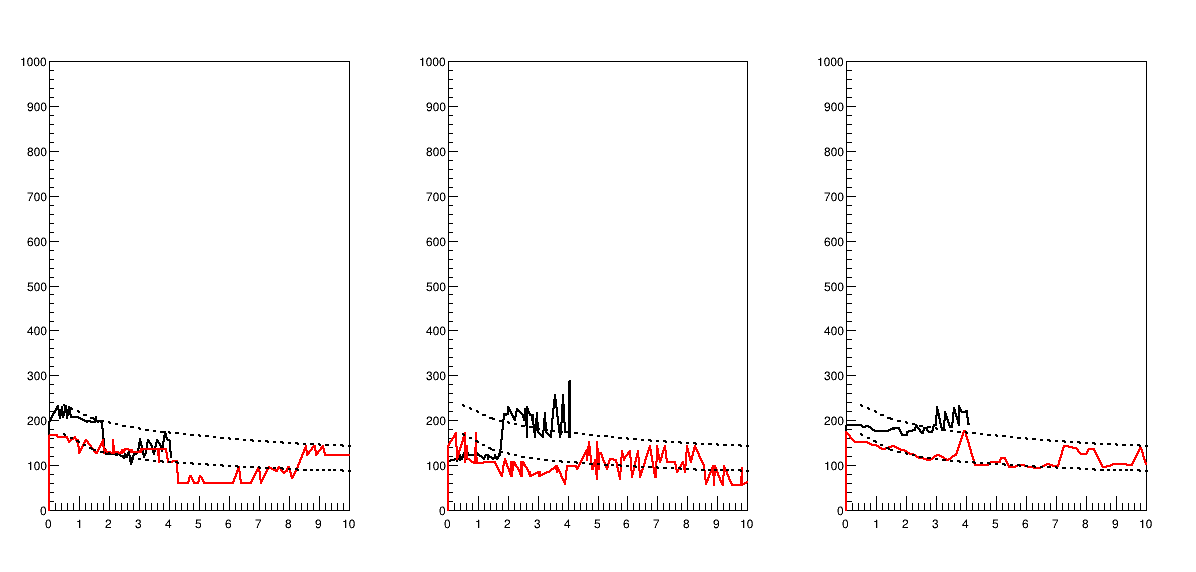

In [29]:
# We plot the dq/dx vs. residual range
# - we choose the vertex closest to the true vertex

truevtx = ublarcvapp.mctools.NeutrinoVertex().getPos3DwSCE(io, sce)
print("true vertex pos w/ SCE correction: ",truevtx)

min_dist = 9999.0
min_ivertex = -1
for ivtx in range( kpsreco.nuvetoed_v.size() ):
    vtx = kpsreco.nuvetoed_v.at(ivtx)
    dist = 0.
    for v in range(3):
        dist += (vtx.pos[v]-truevtx[v])*(vtx.pos[v]-truevtx[v])
    dist = sqrt(dist)
    if dist<3.0 and dist<min_dist:
        min_ivertex = ivtx
        min_dist = dist
if min_ivertex==-1:
    print("No matching vertex")
else:
    bestvtx = kpsreco.nuvetoed_v.at(min_ivertex)
    print("Best vertex, number of tracks: ",bestvtx.track_v.size())
    print("distance to true vertex: ",min_dist," cm")
    g_dict = {}
    for itrack in range(bestvtx.track_v.size()):
        trk = bestvtx.track_v.at(itrack)
        g_dict[itrack] = get_dqdx_tgraphs(trk)
    
    cdqdx.Draw()
    for p in range(3):
        cdqdx.cd(p+1)
        hdqdx.Draw()
        for itrack,g_v in g_dict.items():
            g_v[p].SetLineColor(int(itrack%9)+1)
            g_v[p].SetLineWidth(2)
            g_v[p].Draw("L")
        mu_curve.Draw("L")
        p_curve.Draw("L")
    cdqdx.Update()

In [30]:
# Find Nu Gen-2 Vertex
nuvtx_v = kpsreco.nuvetoed_v
nvertices = nuvtx_v.size()
print("Num vertices",nvertices)
    
gen2_nuvtx = bestvtx
print("  TYPE: ",gen2_nuvtx.keypoint_type)

# Make track and shower 3d scatter plots
ntracks  = gen2_nuvtx.track_v.size()
nshowers = gen2_nuvtx.shower_v.size()
print("Num tracks=",ntracks)
print("Num showers=",nshowers)

# PLOT TRACK FOR VERTEX    
plotdata = []
for itrack in range(ntracks):
    # track-cluster
    print("Make Plots to Track[%d]"%(itrack))
    lfcluster = gen2_nuvtx.track_hitcluster_v[itrack]
    cluster_trace = lardly.data.visualize_larlite_larflowhits( lfcluster, name="c[%d]"%(itrack) )
    cluster_trace["marker"]["color"] = root_colors[ int(itrack%9)+1 ]
    cluster_trace["marker"]["opacity"] = 0.8
    cluster_trace["marker"]["size"] = 2.0
    plotdata.append(cluster_trace)
    
    # track-line                                                                                                                                                      
    track = gen2_nuvtx.track_v.at(itrack)
    trktrace = lardly.data.visualize_larlite_track( track )
    trktrace["name"] = "T[%d]"%(itrack)
    trktrace["line"]["color"] = "rgb(50,50,50)"
    trktrace["line"]["width"] = 5
    trktrace["line"]["opacity"] = 1.0
    #plotdata.append( trktrace )

    kemu = gen2_nuvtx.track_kemu_v.at(itrack)
    kep  = gen2_nuvtx.track_keproton_v.at(itrack)
    llmu = gen2_nuvtx.track_muid_v.at(itrack)
    llp  = gen2_nuvtx.track_protonid_v.at(itrack)
    llr  = gen2_nuvtx.track_mu_vs_proton_llratio_v.at(itrack)
    print("  TRACK[%d] KE(mu)=%.2f KE(p)=%.2f -log(L)_mu=%.2f -log(L)_p=%.2f LLratio=%.2f"%(itrack,kemu,kep,llmu,llp,llr))

# PLOT SHOWER FOR VERTEX                                                                                                                                              
for ishower in range(gen2_nuvtx.shower_v.size()):
    shower = gen2_nuvtx.shower_v.at(ishower)
    shower_trunk = gen2_nuvtx.shower_trunk_v.at(ishower)
    shower_pca   = gen2_nuvtx.shower_pcaxis_v.at(ishower)

    cluster_trace = lardly.data.visualize_larlite_larflowhits( shower, name="S[%d] N[%d]"%(ishower,shower.size()) )
    trunk_trace   = lardly.data.visualize_larlite_track( shower_trunk )

    rgbcolor = np.random.randint(255,size=3)
    cluster_trace["marker"]["color"] = "rgb(%d,%d,0)"%(rgbcolor[0],rgbcolor[1])
    #cluster_trace["marker"]["opacity"] = 0.8
    cluster_trace["marker"]["size"] = 2.0
    plotdata.append(cluster_trace)

    #trunk_trace["line"]["color"] = "rgb(200,0,200)"
    #trunk_trace["line"]["width"] = 5
    #trunk_trace["line"]["opacity"] = 1.0
    #trunk_trace["name"] = "TRNK[%d]"%(ishower)
    #plotdata.append(trunk_trace)

    #pcatrace = lardly.data.visualize_pcaxis( shower_pca )
    #pcatrace["name"] = "SHR[%d]"%(ishower)
    #pcatrace["line"]["color"] = "rgb(255,0,0)"
    #pcatrace["line"]["width"] = 5
    #pcatrace["line"]["opacity"] = 1.0
    #plotdata.append( pcatrace )

    shower_mom_v = gen2_nuvtx.shower_plane_mom_vv.at(ishower)
    sh_p0 = shower_mom_v[0].E()
    sh_p1 = shower_mom_v[1].E()
    sh_p2 = shower_mom_v[2].E()

    shower_dqdx_v = gen2_nuvtx.shower_plane_dqdx_vv.at(ishower)
    dqdx_p0 = shower_dqdx_v[0]
    dqdx_p1 = shower_dqdx_v[1]
    dqdx_p2 = shower_dqdx_v[2]
    print("  SHOWER[%d] KE=(%.2f,%.2f,%.2f) dq/dx=(%.2f,%.2f,%.2f)"%(ishower,sh_p0,sh_p1,sh_p2,dqdx_p0,dqdx_p1,dqdx_p2))


mctruthdata = lardly.data.visualize_nu_interaction( io, do_sce_correction=True  )

# FORM THE PLOT: SHOWING KEYPOINT OUTPUT

# DATA
data = [] + detdata.getlines(color=(10,10,10)) + plotdata + mctruthdata

# LAYOUT
axis_template = {
    "showbackground": True,
    "backgroundcolor": "rgba(100, 100, 100,0.5)",
    "gridcolor": "rgb(50, 50, 50)",
    "zerolinecolor": "rgb(0, 0, 0)",
}


layout = go.Layout(
    title='Neutrino Interaction',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    scene= {
        "xaxis": axis_template,
        "yaxis": axis_template,
        "zaxis": axis_template,
        "aspectratio": {"x": 1, "y": 1, "z": 3},
        "camera": {"eye": {"x": -2, "y": 1, "z": 1},
                   "up":dict(x=0, y=1, z=0)},
        "annotations": [],
    }
)

fig = go.Figure(data=data, layout=layout)
fig.show()

Num vertices 13
  TYPE:  0
Num tracks= 2
Num showers= 0
Make Plots to Track[0]
  TRACK[0] KE(mu)=27.91 KE(p)=70.16 -log(L)_mu=8.96 -log(L)_p=16.74 LLratio=7.78
Make Plots to Track[1]
  TRACK[1] KE(mu)=634.67 KE(p)=908.59 -log(L)_mu=4.70 -log(L)_p=25.76 LLratio=21.07
number of mctracks:  7
